### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра математического моделирования и искусственного интеллекта 

## ОТЧЕТ ПО КОНТРОЛЬНОЙ РАБОТЕ № 1


### Дисциплина: Методы машинного обучения

##### Студент:  Генералов Даниил
##### Группа:   НПИбд-01-21

## Москва 2024
***

### Вариант №22

Текст задания:

1. Набор данных: howell 

2. Независимая переменная: height 

3. Зависимая переменная: weight 

4. Визуализация для независимой переменной – столбчатая диаграмма 

5. Визуализация для зависимой переменной – эмпирическая плотность распределения 

6. Показатель качества регрессии – R^2 (коэффициент детерминации) 



# 1: загружаем данные

In [1]:
try:
    import tensorflow as tf
    import tensorflow_datasets as tfds
    import matplotlib.pyplot as plt
    import pandas
    import numpy as np
except ImportError:
    !pip3 install tensorflow
    !pip3 install tfds-nightly
    !pip3 install matplotlib
    !pip3 install pandas
    !pip3 install numpy
    import tensorflow as tf
    import tensorflow_datasets as tfds
    import matplotlib.pyplot as plt
    import pandas
    import numpy as np

2024-04-19 04:16:47.434924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-19 04:16:48.904056: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
from IPython import display as D
disp = D.display
MD = D.Markdown

In [3]:
data = tfds.load('howell', split='train')
df = tfds.as_dataframe(data)
df.head()

2024-04-19 04:16:51.395662: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-19 04:16:51.776731: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


,age,height,male,weight
0,20.0,154.899994,1,38.200001
1,21.0,155.574997,0,45.529297
2,21.0,146.050003,0,44.763859
3,21.0,163.830002,1,46.776676
4,18.0,149.225006,0,42.127357


In [4]:
df.info()

<class 'tensorflow_datasets.core.as_dataframe.as_dataframe.<locals>.StyledDataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   age     544 non-null    float32
 1   height  544 non-null    float32
 2   male    544 non-null    int32  
 3   weight  544 non-null    float32
dtypes: float32(3), int32(1)
memory usage: 8.6 KB


In [5]:
df = df.drop(columns=['male'])
df.head()

,age,height,weight
0,20.0,154.899994,38.200001
1,21.0,155.574997,45.529297
2,21.0,146.050003,44.763859
3,21.0,163.830002,46.776676
4,18.0,149.225006,42.127357


# 6.1: разбиение на test/train


In [6]:
import random
random.seed('Генералов Даниил')
test_ratio = 0.2

train = pandas.DataFrame(columns=df.columns)
test = pandas.DataFrame(columns=df.columns)
for row_idx in range(len(df)):
    row = df.loc[row_idx, :]
    if random.random() < test_ratio:
        test.loc[len(test), :] = row
    else:
        train.loc[len(train), :] = row

len(train), len(test)

(416, 128)

# 1: анализ данных


In [7]:
disp(MD("## Матрица корреляции:"))
cor = train.corr()
disp(cor)

disp(MD("## Минимальная корреляция:"))
cor_st = cor.stack()
idx = cor_st.idxmin()
print(idx, '->', cor_st[idx])
disp(MD("## Максимальная корреляция:"))
idx = cor_st[cor_st!=1.0].idxmax()
print(idx, '->', cor_st[idx])

## Матрица корреляции:

,age,height,weight
age,1.000000,0.697215,0.690052
height,0.697215,1.000000,0.941922
weight,0.690052,0.941922,1.000000


## Минимальная корреляция:

('age', 'weight') -> 0.6900518884319605


## Максимальная корреляция:

('height', 'weight') -> 0.9419218557199522


# 2: визуализация


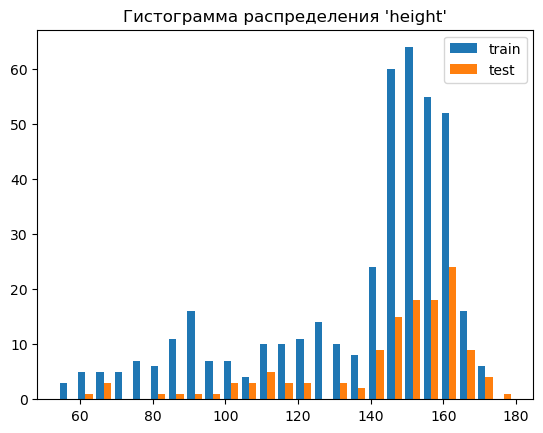

In [8]:
# Независимая переменная
fig, ax = plt.subplots()
ax.hist((train['height'], test['height']), label=['train', 'test'], bins=25)
ax.legend()
ax.set_title("Гистограмма распределения 'height'")
plt.show()

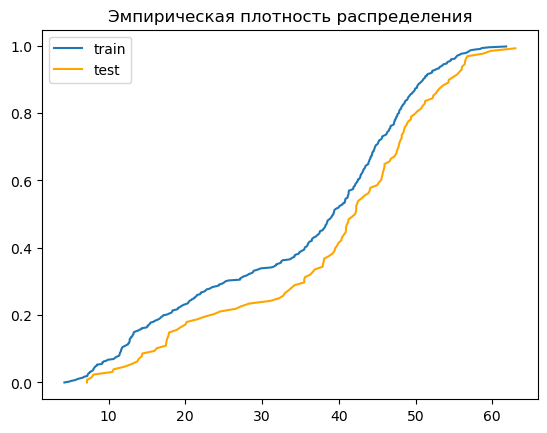

In [9]:
tx_train = np.sort(train['weight'])
ty_train = np.arange(len(tx_train)) / (len(tx_train)+0.0)

fig, ax = plt.subplots()
plt.plot(tx_train, ty_train, label='train')
ax.set_title("Эмпирическая плотность распределения")

tx_test = np.sort(test['weight'])
ty_test = np.arange(len(tx_test)) / (len(tx_test)+0.0)

plt.plot(tx_test, ty_test, color='orange', label='test')
plt.legend()

# 3: диаграма рассеивания

Отдельно стоящих точек нет

<Axes: title={'center': 'Диаграмма рассеивания'}, xlabel='height', ylabel='weight'>

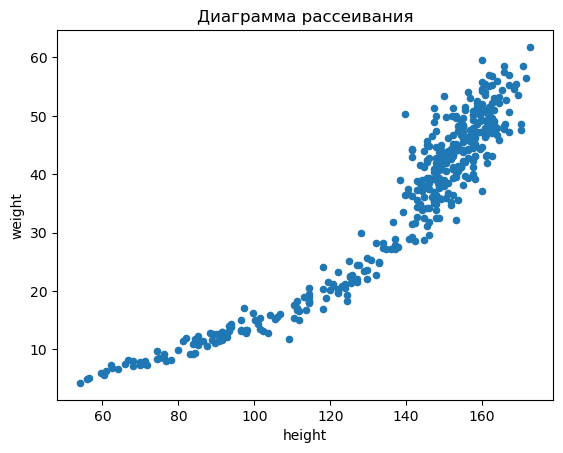

In [10]:
train.plot.scatter('height', 'weight', title='Диаграмма рассеивания')

# 4: линейная регрессия


In [11]:
# явной схемой
class SimpleLinReg:
    def __init__(self):
        self.a_ = None
        self.b_ = None

    def fit(self, x_train, y_train):
        assert x_train.ndim == 1, \
            "В данных должен быть один признак"
        assert len(x_train) == len(y_train), \
            "Данные должны иметь одинаковый размер"

        x_mean = np.mean(x_train)
        y_mean = np.mean(y_train)

        self.a_ = (x_train - x_mean).dot(y_train - y_mean) / \
                  (x_train - x_mean).dot(x_train - x_mean)
        self.b_ = y_mean - self.a_ * x_mean

        return self
    def predict(self, x_predict):
        assert x_predict.ndim == 1, \
            "В данных должен быть один признак"
        assert self.a_ is not None and self.b_ is not None, \
            "Модель вначале должна быть обучена"

        return np.array([self._predict(x) for x in x_predict])

    def _predict(self, x_single):
        return self.a_ * x_single + self.b_
    def __repr__(self):
        return f"SimpleLinReg(y = {self.a_}x + {self.b_})"
    
    # https://stackoverflow.com/a/61548813/5936187
    def r_squared(self, x_predict, y_true):
        y_bar = y_true.mean()
        y_hat = self.predict(x_predict)
        ss_tot = ((y_true-y_bar)**2).sum()
        ss_res = ((y_true-y_hat)**2).sum()
        return 1 - (ss_res/ss_tot)

x = train["height"]
y = train["weight"]
x_test = test["height"]
y_test = test["weight"]

regression = SimpleLinReg()
regression.fit(x, y)
r2 = regression.r_squared(x_test, y_test)
regression

SimpleLinReg(y = 0.4931890744808294x + -32.618772403482915)

In [12]:
y_hat_explicit_train = regression.predict(x)
y_hat_explicit_test = regression.predict(x_test)

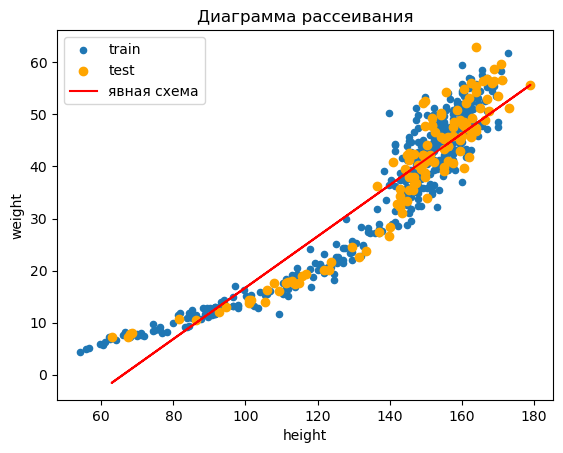

In [13]:
ax = train.plot.scatter('height', 'weight', title='Диаграмма рассеивания', label='train')
ax.scatter(test['height'], test['weight'], color='orange', label='test')
ax.plot(x_test, y_hat_explicit_test, color='r', label='явная схема')
ax.legend()

In [14]:
mean_sq_error = sum([(lin - actual)**2 for lin, actual in zip(y_hat_explicit_test, y_test)]) / len(y_test)
mean_sq_error

25.441917756669504

In [15]:
# нейросетью
model = tf.keras.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(1),
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    metrics=["r2_score"]
)

In [17]:
x = np.asarray(train["height"]).astype(np.float32)
y = np.asarray(train["weight"]).astype(np.float32)
x_test = np.asarray(test["height"]).astype(np.float32)
y_test = np.asarray(test["weight"]).astype(np.float32)

model.fit(x, y, epochs=1000, verbose=0)

In [18]:
model_predict = model.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


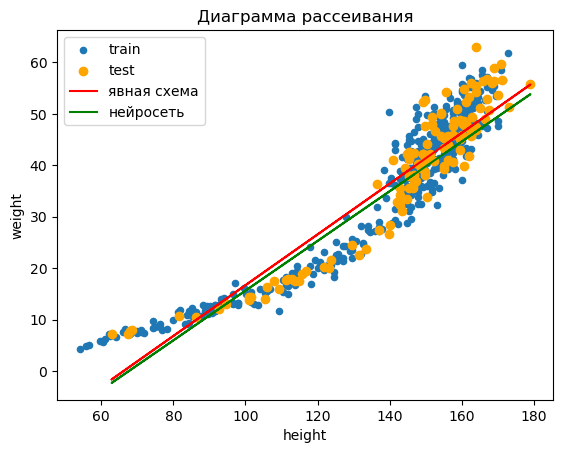

In [19]:
# 5: диаграмма рассеивания
ax = train.plot.scatter('height', 'weight', title='Диаграмма рассеивания', label='train')
ax.scatter(test['height'], test['weight'], color='orange', label='test')
ax.plot(x_test, y_hat_explicit_test, color='r', label='явная схема')
ax.plot(x_test, model_predict, color="g", label="нейросеть")
ax.legend()

In [20]:
x_test = np.asarray(test["height"]).astype(np.float32)
y_test = np.asarray(test["weight"]).astype(np.float32)

loss, r2_model = model.evaluate(x_test, y_test)
disp(MD(f"## R^2 явной схемы: {r2}"))
disp(MD(f"## R^2 нейросети: {r2_model} (- {r2 - r2_model})"))
if r2 > r2_model:
    disp(MD('## -> явная схема лучше'))
else:
    disp(MD('## -> нейросеть лучше'))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3591 - r2_score: 0.8343  


## R^2 явной схемы: 0.8697705142315317

## R^2 нейросети: 0.8522513508796692 (- 0.017519163351862543)

## -> явная схема лучше

In [21]:
mean_sq_error_neural = sum([(lin - actual)**2 for lin, actual in zip(model_predict, y_test)]) / len(y_test)
mean_sq_error, mean_sq_error_neural

(25.441917756669504, array([28.864504], dtype=float32))

# 6: нормализация для многомерного анализа


In [22]:
## нормализация age и height через Tensorflow
n = np.array([x for x in train if x != "weight"])
features = np.array(train[n])
disp(n)
disp(features[:5])
normalizer = tf.keras.layers.Normalization()
normalizer.adapt(np.array(features))

array(['age', 'height'], dtype='<U6')

array([[20.0, 154.89999389648438],
       [21.0, 146.0500030517578],
       [5.0, 101.5999984741211],
       [25.0, 147.32000732421875],
       [38.0, 147.32000732421875]], dtype=object)

In [23]:
print(normalizer.mean.numpy())
print(normalizer.variance.numpy())

[[ 28.694832 136.51624 ]]
[[447.5423 799.6701]]


In [24]:
## нормализация weight вручную
y_train = np.array(train['weight'])
y_train_norm = (y_train - y_train.mean()) / y_train.std()
y_train_norm = y_train_norm.astype(np.float32)
y_train_norm.mean(), y_train_norm.std()

(-1.1462432e-09, 1.0)

In [25]:
y_test = np.array(test['weight'])
y_test_norm = (y_test - y_test.mean()) / y_test.std()
y_test_norm = y_test_norm.astype(np.float32)

y_test_norm.mean(), y_test_norm.std()

(3.7252903e-09, 1.0)

# 7: нейросети с нормализацией и регуляризацией


In [26]:
feature = np.array(train['height'])

l0_model = tf.keras.Sequential([
    tf.keras.layers.Input((2,)),
    normalizer,
    tf.keras.layers.Dense(units=1),
])
l0_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 2)              │             5 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8 (36.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 5 (24.00 B)

In [27]:
l0_model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    metrics=["r2_score"]
)

x_train = np.asarray(train[n]).astype(np.float32)
x_test = np.asarray(test[n]).astype(np.float32)

l0_hist = l0_model.fit(x_train, y_train_norm, epochs=1000, verbose=0, validation_split=0.2)

In [28]:
test_results = {}

test_results['linear'] = l0_model.evaluate(
    np.asarray(x_test).astype(np.float32),
    np.asarray(y_test_norm).astype(np.float32), verbose=0)

In [29]:
# Модель с L1
l1_model = tf.keras.Sequential([
    tf.keras.layers.Input((2,)),
    normalizer,
    tf.keras.layers.Dense(units=1, kernel_regularizer=tf.keras.regularizers.L1(l1=0.01)),
])

l1_model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    metrics=["r2_score"]
)

l1_hist = l1_model.fit(x_train, y_train_norm, epochs=1000, verbose=0, validation_split=0.2)

test_results['l1'] = l1_model.evaluate(
    np.asarray(x_test).astype(np.float32),
    np.asarray(y_test_norm).astype(np.float32), verbose=0)

In [30]:
# Модель с L2
l2_model = tf.keras.Sequential([
    tf.keras.layers.Input((2,)),
    normalizer,
    tf.keras.layers.Dense(units=1, kernel_regularizer=tf.keras.regularizers.L2(l2=0.01)),
])

l2_model.compile(
    loss=tf.keras.losses.MAE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.05),
    metrics=["r2_score"]
)

l2_hist = l2_model.fit(x_train, y_train_norm, epochs=1000, verbose=0, validation_split=0.2)

test_results['l2'] = l2_model.evaluate(
    np.asarray(x_test).astype(np.float32),
    np.asarray(y_test_norm).astype(np.float32), verbose=0)

In [31]:
test_results

{'linear': [0.3517463803291321, 0.8204483389854431],
 'l1': [0.3951987624168396, 0.7872925400733948],
 'l2': [0.371818870306015, 0.8074440360069275]}

# 8 + 9: визуализация лучшей модели


{'linear': [0.3517463803291321, 0.8204483389854431],
 'l1': [0.3951987624168396, 0.7872925400733948],
 'l2': [0.371818870306015, 0.8074440360069275]}

## Лучший показатель у модели LINEAR R^2 = 0.8204483389854431

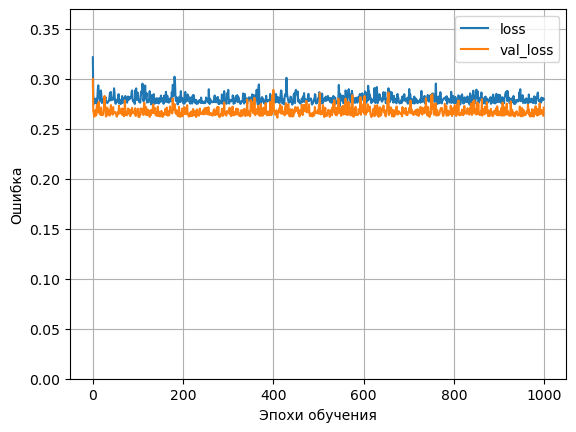

In [32]:
models = {
    'linear': [l0_model, l0_hist],
    'l1': [l1_model, l1_hist],
    'l2': [l2_model, l2_hist]
}

def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, max(history.history['loss'])*1.15])
  plt.xlabel('Эпохи обучения')
  plt.ylabel('Ошибка')
  plt.legend()
  plt.grid(True)

disp(test_results)

best_scoring_name = max(list(test_results), key=lambda x: test_results[x][1])
best_model, best_hist = models[best_scoring_name]
disp(MD(f"## Лучший показатель у модели {best_scoring_name.upper()} R^2 = {test_results[best_scoring_name][1]}"))
plot_loss(best_hist)

# 10: визуализация предсказаний модели

<IPython.core.display.Javascript object>


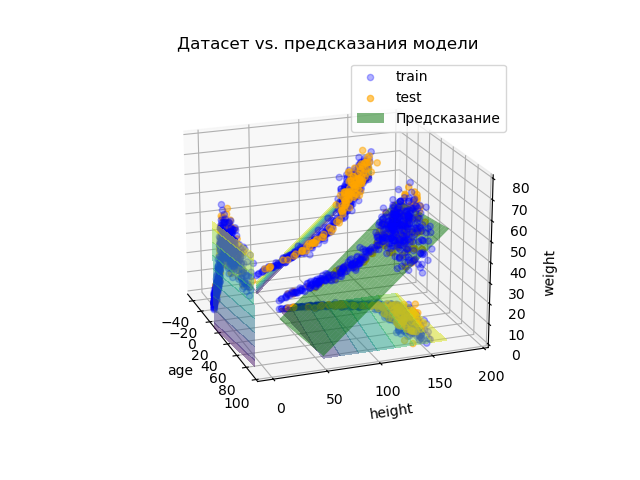

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [34]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.set_xlabel('age')
ax.set_ylabel('height')
ax.set_zlabel('weight')

x_train = train['age']
y_train = train['height']
z_train = train['weight']

x_test = test['age']
y_test = test['height']
z_test = test['weight']

ax.scatter(x_train, y_train, z_train, label='train', color='blue', alpha=0.3)
ax.scatter(x_test, y_test, z_test, label='test', color='orange', alpha=0.6)



x = np.linspace(min(x_train), max(x_train), 20)
y = np.linspace(min(y_train), max(y_train), 20)
X,Y = np.meshgrid(x,y)

predict_points = np.array(list(zip(np.ravel(X), np.ravel(Y))))
Z = best_model.predict(predict_points)
Z = Z.reshape(X.shape)

std = train['weight'].std()
mean = train['weight'].mean()
Z = (Z * std) + mean

xo = -50
yo = -10
zo = 0

ax.plot_surface(X,Y,Z, label='Предсказание', color='green', alpha=0.5)
ax.contourf(X,Y,Z, zdir='z', offset=zo, alpha=0.5)
ax.contourf(X,Y,Z, zdir='x', offset=xo, alpha=0.5)
ax.contourf(X,Y,Z, zdir='y', offset=yo, alpha=0.5)

ax.scatter(x_train, y_train, color='blue', alpha=0.3, zdir='z', zs=zo)
ax.scatter(y_train, z_train, color='blue', alpha=0.3, zdir='x', zs=xo)
ax.scatter(x_train, z_train, color='blue', alpha=0.3, zdir='y', zs=yo)

ax.scatter(x_test, y_test, color='orange', alpha=0.5, zdir='z', zs=zo)
ax.scatter(y_test, z_test, color='orange', alpha=0.5, zdir='x', zs=xo)
ax.scatter(x_test, z_test, color='orange', alpha=0.5, zdir='y', zs=yo)

ax.view_init(elev=20, azim=-20, roll=0)
ax.set_xlim(xo, 100)
ax.set_ylim(yo, 200)
ax.set_zlim(zo, 80)
ax.set_title("Датасет vs. предсказания модели")
ax.legend()